In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plotter
from scipy import stats
from numpy import linalg
from sklearn import datasets
from scipy.io import loadmat
from scipy.sparse import csgraph
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.neighbors import kneighbors_graph
from scipy.optimize import linear_sum_assignment

# Importing Datasets

In [ ]:
def mat2pd(file_mat, revert = False):
    mat = loadmat(file_mat)
    
    cols = len(mat['fea'])
    rows = len(mat['fea'][0])
    data = []
    if (revert):
      cols,rows = rows,cols
      for row in range(rows):
        a_row = []
        for col in range(cols):
          a_row.append(mat['fea'][row][col])        
        a_row.append(mat['gnd'][row][0])
        data.append(a_row)
      df = pd.DataFrame(data)
      return(df)
    else:
      for row in range(rows):
        a_row = []
        for col in range(cols):
          a_row.append(mat['fea'][col][row])
        a_row.append(mat['gnd'][row][0])
        data.append(a_row)
      df = pd.DataFrame(data)
      return(df)

iris = mat2pd('iris_uni.mat')

jaffe = mat2pd('jaffe.mat',True)

pixraw = mat2pd('pixraw10P.mat')

wine = mat2pd('wine_uni.mat')

warp = mat2pd('warpPIE10P.mat')

halfcircles = mat2pd('halfcircles.mat')

threecircles = mat2pd('threecircles.mat')


# Functions

In [ ]:
def visualize_dataset(title, data, labels):
    plotter.scatter(data[:, 0], data[:, 1], c=labels)
    plotter.title(title)   
    plotter.show()
    
def initialize_L(laplacians):
    L = np.zeros(laplacians[0].shape)
    for i in range(len(laplacians)):
        L += laplacians[i]
 
    return L
 
 
def calculate_U(L, clusters):
    U, sigma, _ = linalg.svd(L)
    return U[:, 0: clusters]
 
 
def update_L(U_list):
    L = np.zeros((U_list[0].shape[0], U_list[0].shape[0]))
    for i in range(len(U_list)):
        L += np.matmul(U_list[i], np.transpose(U_list[i]))
 
    return L
 
 
def calculate_obj(U, L):
    return np.trace(np.matmul(np.transpose(U), np.matmul(L, U)))
 
 
def update_alpha(alpha_0, objs):
    return alpha_0 * np.power(np.std(objs), 2)

def gaussian(dataset):
    gamma = 0.1
    landa = 1/(2*(gamma**2))
    result = []
    for row1 in dataset:
      row = []
      for row2 in dataset:
        row.append(np.exp(landa * squared_euclidean_distance(row1, row2)))
      result.append(row)
    return result
 
 
def squared_euclidean_distance(data1, data2):
    subtract = data1 - data2;
    return np.matmul(subtract, subtract)
 
 
def euclidean_distance(data1, data2):
    return np.sqrt(squared_euclidean_distance(data1, data2))
 
def k_means_clustering(dataset, clusters, rng):
    k_means = KMeans(n_clusters=clusters, random_state=rng)
    return k_means.fit_predict(dataset)
 
 
def spectral_clustering(dataset, rng, k = 5):
    clusters = len(np.unique(dataset.iloc[:, -1].values))
    dataset = dataset.iloc[:, :-1]
    L = compute_laplacian(dataset, k, 0.5, 'e')
    U = calculate_U(L, clusters)
    return k_means_clustering(U, clusters, rng)
 
 
def elsc_clustering(dataset, rng , methods = ['e', 's', 'p'], a = 5, b = 9):
    clusters = len(np.unique(dataset.iloc[:, -1].values))
    dataset = dataset.iloc[:, :-1]
    alpha = 0.001
    input_laplacians = generate_input_laplacians(dataset, methods, a, b)

    L = initialize_L(input_laplacians)
    U = calculate_U(L, clusters)
 
    U_list = []
    objs = []
    alpha_0 = alpha
 
    for i in range(len(input_laplacians)):
        U_list.append(calculate_U(input_laplacians[i], clusters))
        objs.append(calculate_obj(U_list[i], input_laplacians[i]))
        alpha = update_alpha(alpha_0, objs)
 
    counter = 0
    while counter < 10:
        temp = alpha * np.matmul(U, np.transpose(U))
        for i in range(len(input_laplacians)):
            modified_L = input_laplacians[i] + temp
            U_list[i] = calculate_U(modified_L, clusters)
            objs[i] = calculate_obj(U_list[i], modified_L)
            alpha = update_alpha(alpha_0, objs)
 
        L = update_L(U_list)
        U = calculate_U(L, clusters)
 
        counter += 1
 
    for row in range(U.shape[0]):
      temp = 0
      for col in range(U.shape[1]):
        temp += U[row, col] ** 2
      U[row, :] = U[row, :] / np.sqrt(temp)
 
    return k_means_clustering(U, clusters, rng)

def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)  
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

## Laplacian Functions

In [ ]:
def generate_input_laplacians(dataset, methods = ['e', 's', 'p'], a = 5, b = 9):
    laplacians = [ compute_laplacian(dataset, k, 0.5, m) for k in range(a,b) for m in methods ]
    return laplacians

def compute_kernel(D, k, coef):
  data_count, feature_count = D.shape

  dump = np.zeros((data_count, k))

  for i in range(data_count):
    indices = np.argpartition(D[i, :], k)
    dump[i, :] = D[i, indices[: k]]
    D[i, indices[: k]] = float('inf')
  
  sigma = np.mean(dump) * coef

  dump = np.exp(-dump / (2 * sigma ** 2))

  sumD = np.sum(dump, axis=1) + 1e-10;

  for i in range(data_count):
    dump[i, :] /= sumD[i]

  kernel = np.zeros(D.shape)

  for i in range(data_count):
    index = 0
    for j in range(feature_count):
      if D[i, j] == float('inf'):
        kernel[i, j] = dump[i, index]
        index += 1

  kernel = (kernel + np.transpose(kernel)) / 2

  return kernel


def compute_laplacian(dataset, k, coef, method):
  if (method == 'e'):
    dis = squareform(pdist(dataset))
  elif (method == 's'):
    rho , pval = stats.spearmanr(dataset, axis=1)
    dis = rho
  else:
    r = np.corrcoef(dataset)
    dis = 1 - r

  kernel = compute_kernel(dis, k, coef)
  sums = kernel.sum(axis=1)
  sums = np.sqrt(1 / sums)
  M = np.multiply(sums[np.newaxis, :], np.multiply(kernel, sums[:, np.newaxis]))
  return M



# Testing

## synthetic datasets

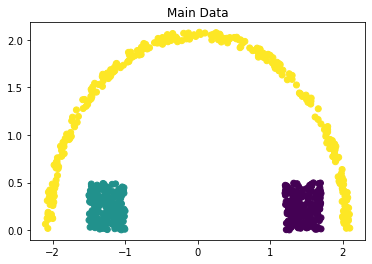

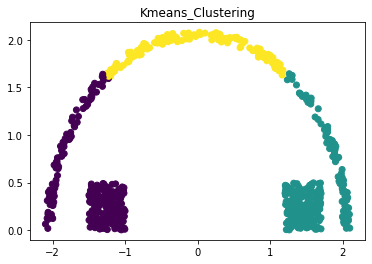

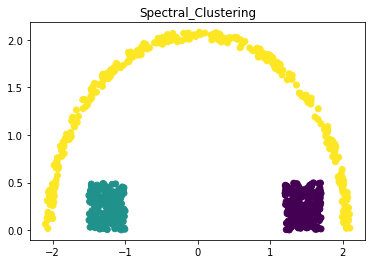

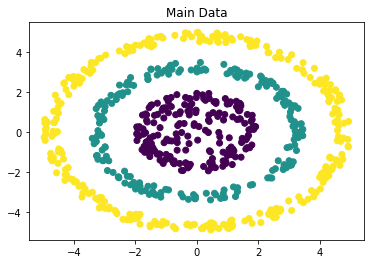

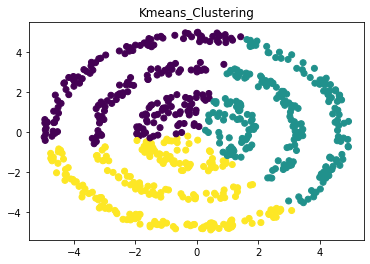

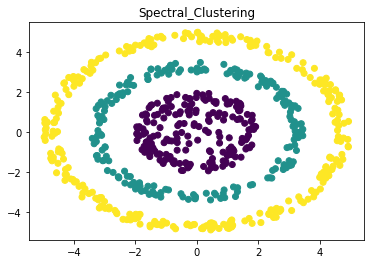

In [ ]:
rng = 5

labels1 = k_means_clustering(dataset=halfcircles.iloc[:, :-1].values , clusters = len(np.unique(halfcircles.iloc[:, -1])),  rng=rng)
labels2 = spectral_clustering(dataset=halfcircles, rng=rng, k = 15)

visualize_dataset("Main Data", halfcircles.iloc[:, :-1].values, halfcircles.iloc[:, -1].values)
visualize_dataset("Kmeans_Clustering", halfcircles.iloc[:, :-1].values, labels1)
visualize_dataset("Spectral_Clustering", halfcircles.iloc[:, :-1].values, labels2)

labels1 = k_means_clustering(dataset=threecircles.iloc[:, :-1].values , clusters = len(np.unique(threecircles.iloc[:, -1])),  rng=rng)
labels2 = spectral_clustering(dataset=threecircles, rng=rng, k = 14)

visualize_dataset("Main Data", threecircles.iloc[:, :-1].values, threecircles.iloc[:, -1].values)
visualize_dataset("Kmeans_Clustering", threecircles.iloc[:, :-1].values, labels1)
visualize_dataset("Spectral_Clustering", threecircles.iloc[:, :-1].values, labels2)

## real datasets

In [ ]:
ds = iris
labels = elsc_clustering(dataset=ds , rng=rng)
iris_ELSC = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)
labels = spectral_clustering(dataset=ds, rng=rng)
iris_sc = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)

ds = jaffe
labels = elsc_clustering(dataset=ds , rng=rng)
jaffe_ELSC = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)
labels = spectral_clustering(dataset=ds, rng=rng)
jaffe_sc = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)

ds = pixraw
labels = elsc_clustering(dataset=ds , rng=rng)
pixraw_ELSC = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)
labels = spectral_clustering(dataset=ds, rng=rng)
pixraw_sc = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)

ds = wine
labels = elsc_clustering(dataset=ds , rng=rng)
wine_ELSC = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)
labels = spectral_clustering(dataset=ds, rng=rng , k = 7)
wine_sc = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)

ds = warp
labels = elsc_clustering(dataset=ds , rng=rng, a = 2, b = 10)
warp_ELSC = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)
labels = spectral_clustering(dataset=ds, rng=rng)
warp_sc = round(cluster_acc(labels, ds.iloc[:, -1].values) * 100, 2)

print("\t\t\t  SC\t\t\t  ELSC")
print("-"*85)
print("iris:\t\t\t", iris_sc," %\t\t", iris_ELSC," %")
print("jaffe:\t\t\t", jaffe_sc,"%\t\t", jaffe_ELSC,"%")
print("pixraw:\t\t\t", pixraw_sc," %\t\t", pixraw_ELSC," %")
print("wine:\t\t\t", wine_sc,"%\t\t", wine_ELSC," %")
print("warp:\t\t\t", warp_sc,"%\t\t", warp_ELSC,"%")

			  SC			  ELSC
-------------------------------------------------------------------------------------
iris:			 90.0  %		 96.0  %
jaffe:			 95.31 %		 98.12 %
pixraw:			 94.0  %		 94.0  %
wine:			 72.47 %		 74.16  %
warp:			 44.29 %		 50.48 %
